In [1]:
import datetime as dt
import polars as pl
import tensorflow as tf

## Download Data

In [2]:
data_df = pl.read_parquet(
    "data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.parquet"
)

In [3]:
data_df.head()

Timestamp,Epoch,Close,Volume,Log_Close,Intraday_Return
"datetime[μs, UTC]",i64,f64,f64,f64,f64
2015-01-10 00:00:00 UTC,1420848000,293.89,46.439149,5.683206,null
2015-01-10 00:01:00 UTC,1420848060,292.99,15292.23876,5.680138,0.003067
2015-01-10 00:02:00 UTC,1420848120,294.21,16767.104859,5.684294,0.004155
2015-01-10 00:03:00 UTC,1420848180,294.21,753.700847,5.684294,0.0
2015-01-10 00:04:00 UTC,1420848240,294.26,2307.808347,5.684464,0.00017


## Calculate Total Variation and downsample to daily ticks

In [4]:
roll_df = (
    data_df.set_sorted("Timestamp")
    .group_by_dynamic("Timestamp", every="24h", label="right", closed="right")
    .agg(
        Epoch=pl.col.Epoch.last(),
        Close=pl.col.Close.last(),
        Log_Close=pl.col.Log_Close.last(),
        Tot_Var=pl.col.Intraday_Return.sum(),
        Volume=pl.col.Volume.sum(),
    )
    .with_columns(
        Timestamp=pl.col.Timestamp.dt.date(),
        Daily_Return=pl.col.Log_Close.diff(),
        Log_Volume_Diff=pl.col.Volume.log().diff(),
    )
)
roll_df.head()

Timestamp,Epoch,Close,Log_Close,Tot_Var,Volume,Daily_Return,Log_Volume_Diff
date,i64,f64,f64,f64,f64,f64,f64
2015-01-10,1420848000,293.89,5.683206,0.0,46.439149,null,null
2015-01-11,1420934400,275.0,5.616771,1.110708,8.3806e6,-0.066434,12.103285
2015-01-12,1421020800,266.34,5.584774,0.873428,3.4733e6,-0.031997,-0.880824
2015-01-13,1421107200,267.19,5.58796,1.002807,2.8190e6,0.003186,-0.208721
2015-01-14,1421193600,225.73,5.41934,2.747416,1.4308e7,-0.16862,1.624432


## Calculate 30d realized volatility

In [5]:
start_date = dt.date(2015, 1, 10)
vol_df = roll_df.with_columns(
    Real_30d_Vol=(pl.col.Daily_Return**2)
    .sum()
    .rolling("Timestamp", period="30d")
    .sqrt(),
).filter(pl.col.Timestamp >= start_date + dt.timedelta(days=30))
vol_df.head()

Timestamp,Epoch,Close,Log_Close,Tot_Var,Volume,Daily_Return,Log_Volume_Diff,Real_30d_Vol
date,i64,f64,f64,f64,f64,f64,f64,f64
2015-02-09,1423440000,223.92,5.411289,1.191253,3.0971e6,-0.019372,0.344522,0.450103
2015-02-10,1423526400,220.91,5.397755,1.276161,4.2756e6,-0.013533,0.322464,0.445379
2015-02-11,1423612800,221.05,5.398389,0.949794,1.5058e6,0.000634,-1.043569,0.444229
2015-02-12,1423699200,219.66,5.392081,0.693088,2.3604e6,-0.006308,0.449469,0.444262
2015-02-13,1423785600,223.2,5.408068,0.667858,1.5643e6,0.015987,-0.411403,0.411329


## Select features to be used for Model Development

In [6]:
model_data = vol_df.select(["Tot_Var", "Daily_Return", "Real_30d_Vol"])
display(model_data.head())

n_samples = model_data.height
train_pct, val_pct = 0.7, 0.2
train_cutoff = int(n_samples * train_pct)
val_cutoff = int(n_samples * (train_pct + val_pct))

train_df = model_data[:train_cutoff]
val_df = model_data[train_cutoff:val_cutoff]
test_df = model_data[val_cutoff:]

print(train_df.shape)
print(val_df.height)
print(test_df.height)

Tot_Var,Daily_Return,Real_30d_Vol
f64,f64,f64
1.191253,-0.019372,0.450103
1.276161,-0.013533,0.445379
0.949794,0.000634,0.444229
0.693088,-0.006308,0.444262
0.667858,0.015987,0.411329


(1570, 3)
448
225


## Model Development

In [7]:
from window_generator import WindowGenerator

In [8]:
window = WindowGenerator(
    input_width=60,
    label_width=60,
    shift=30,
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    label_columns=["Real_30d_Vol"],
    norm_flag=False,
)
display(window)

Total window size: 90
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
Label indices: [30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77
 78 79 80 81 82 83 84 85 86 87 88 89]
Label column name(s): ['Real_30d_Vol']
Norm flag: False

## Benchmark models
### EchoModel uses value at T to predict T + n
### LinearModel is simple linear regression

Model: "echo_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 0 (0.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

12/12 [==============================] - 0s 581us/step - loss: 0.0270 - mean_absolute_error: 0.1036


[0.026988541707396507, 0.10360842198133469]

5/5 [==============================] - 0s 695us/step - loss: 0.0037 - mean_absolute_error: 0.0541


[0.003721125889569521, 0.05413185805082321]

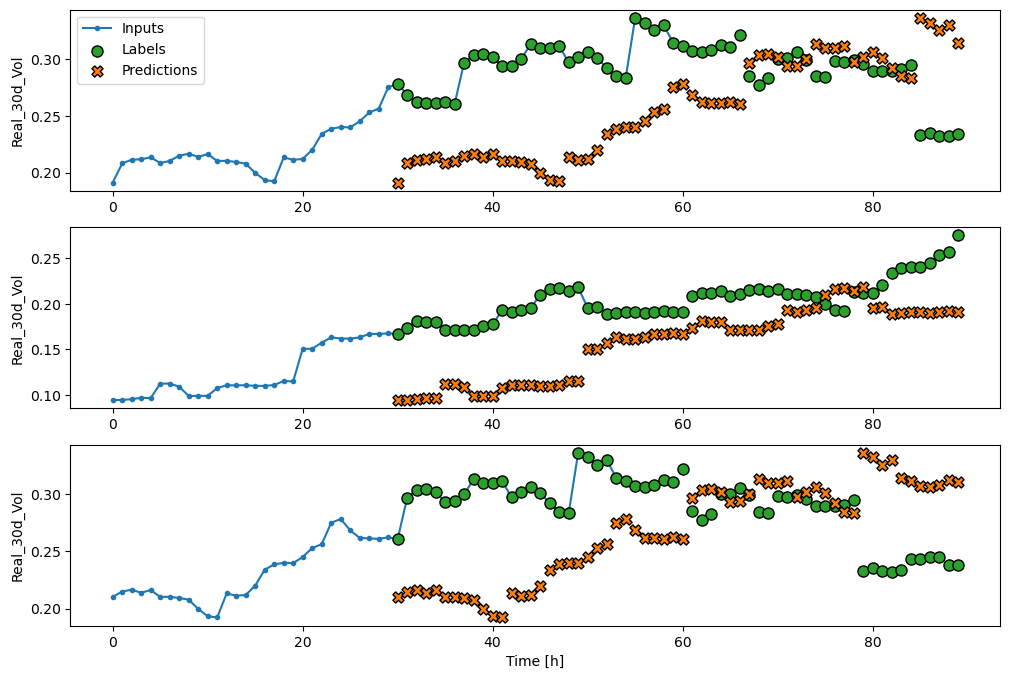

In [9]:
from models.echo import EchoModel

echo_model = EchoModel(label_index=window.column_indices["Real_30d_Vol"])
history = window.compile_and_fit(echo_model)
display(echo_model.summary())
display(echo_model.evaluate(window.val))
display(echo_model.evaluate(window.test))
window.plot(echo_model, use_test=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 60, 1)             4         
                                                                 
Total params: 4 (16.00 Byte)
Trainable params: 4 (16.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

12/12 [==============================] - 0s 543us/step - loss: 0.0153 - mean_absolute_error: 0.0707


[0.015330074355006218, 0.07065827399492264]

5/5 [==============================] - 0s 672us/step - loss: 0.0030 - mean_absolute_error: 0.0463


[0.002978625474497676, 0.04626050591468811]

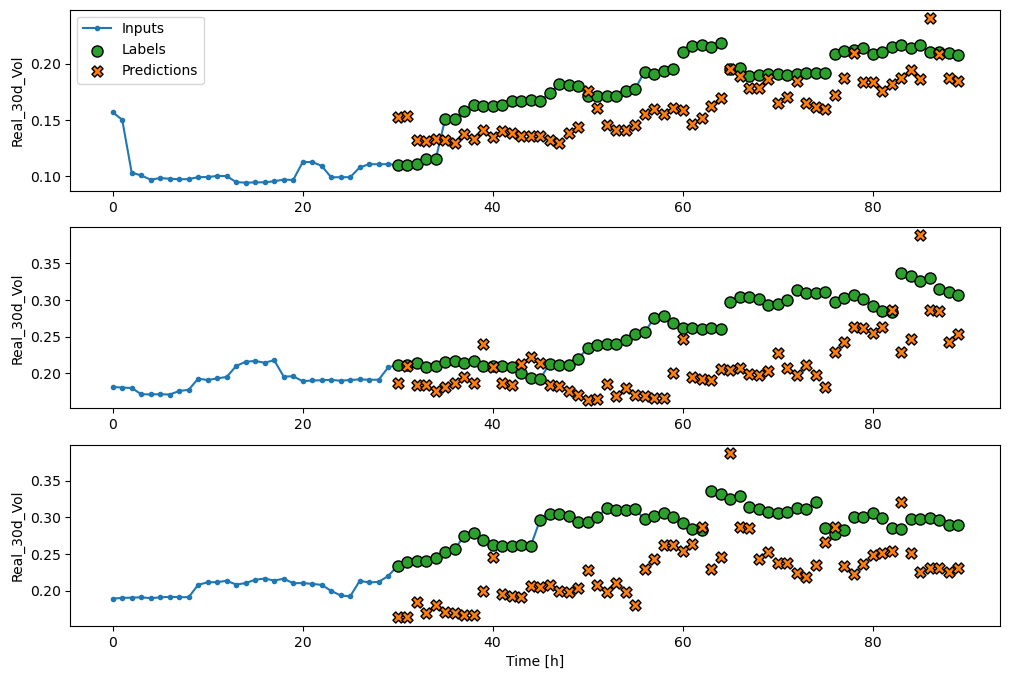

In [10]:
from models.linear import Linear

linear_model = Linear()
history = window.compile_and_fit(linear_model)
display(linear_model.summary())
display(linear_model.evaluate(window.val))
display(linear_model.evaluate(window.test))
window.plot(linear_model, use_test=True)